# ML-2: Trees, Model Interrogation and Bayesian Workflow
# Homework 2: Rossman Kaggle: Forecasting Sales
# Part 4 : Modelling with embeddings!
**ML-2 Cohort 1** <br>
**Instructor: Dr. Rahul Dave**<br>
**Max Score: 100** <br>

In [13]:
#importing libraries
import numpy as np
import scipy.stats
import scipy.special
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape
from keras.layers import Concatenate
from keras.layers.embeddings import Embedding
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import pickle
import csv
import joblib
from datetime import datetime
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

We will repeat the first initial steps again from Part 2

Lets import the feature_train_data.pickle file and set X,y values from the pickle file

In [2]:
f = open('feature_train_data.pickle', 'rb')
(X, y) = pickle.load(f)

In [3]:
# we will split the train_ratio and 90% and 10% and set the train_size
train_ratio = 0.9
num_records = len(X)
train_size = int(train_ratio * num_records)

In [4]:
#lets look at our data
X[1], y[1]

(array([   0, 1058,    1,    0,    0,    0,    0,    1]), 4491)

The next set of inputs is following: Write the code for this yourself

1. Do you want to one hot encode the data?
2. Do you want to provide embeddings as input - this will be set to True for models with entity embeddings
3. Do you want to save the emmbeddings? - again set to true if you want to entity embeddings
4. if 3 is set to true, we want to save them to a embeddings.pickle


In [5]:
#your code here
embeddings_as_input=True
one_hot_as_input = False
save_embeddings = False

## Now lets work with Models with Entity embedding!!

Now that you have saved embeddings - push this into the other models as an input with X. 

How will we do this? 

We need to update our X values. 

1. We will define a function called embed_features, which will combine the embedding with X. 
2. Call this function and update it with the inital X values taken from the pickle file - features_train_data
3. Then split you data, X_emb - into Xtrain and X_Val, y_train and y_val remain the same
4. Sample the data

In [6]:
#call our saved embeddings from part 3
saved_embeddings_fname = 'files/embeddings.pickle'

In [7]:
#combining embedding
def embed_features(X, saved_embeddings_fname):
    f_embeddings = open(saved_embeddings_fname, "rb")
    embeddings = pickle.load(f_embeddings)

    index_embedding_mapping = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    X_embedded = []

    (num_records, num_features) = X.shape
    for record in X:
        embedded_features = []
        for i, feat in enumerate(record):
            feat = int(feat)
            if i not in index_embedding_mapping.keys():
                embedded_features += [feat]
            else:
                embedding_index = index_embedding_mapping[i]
                embedded_features += embeddings[embedding_index][feat].tolist()

        X_embedded.append(embedded_features)

    return np.array(X_embedded)

**Explain what is happening the function above**

The above function will replace all the features except `'store_is_open'` and `'promo'` to their new value which are saved in `embeddings.pickle` in part3.

### Embedding with X - input

In [8]:
#check if embedding is needed, if yes call embed_features - with X and the embeddings passed to it - call this new X as X_emb
if embeddings_as_input:
    X_emb = embed_features(X, saved_embeddings_fname)

Split the train and validation based on train size and on the new X_emb values from the previous code

In [9]:
#update the X_train and X_val
X_train, X_val = X_emb[:train_size], X_emb[:train_size]
y_train, y_val = y[:train_size], y[:train_size]

X_train.shape, X_val.shape

((759904, 42), (759904, 42))

In [10]:
def sample(X, y, n):
    '''random samples'''
    num_row = X.shape[0]
    indices = np.random.randint(num_row, size=n)
    return X[indices, :], y[indices]

In [11]:
X_train, y_train = sample(X_train, y_train, 200000)  # Simulate data sparsity
print("Number of samples used for training: " + str(y_train.shape[0]))

Number of samples used for training: 200000


## Add the embeddings into the Models and check their MAPE!

All the models defined here will have the same parameters as the ones defined in Part 2!

In [12]:
#defining mape
def MAPE(Y_actual,Y_Predicted):
    y_true, y_pred = np.array(Y_actual), np.array(Y_Predicted)
    mape = (1/len(y_true)) * np.sum(np.absolute((y_true - y_pred) / y_true))
    return mape 

### Model 1: Random Forests

In [14]:
# instantiate a RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200, max_depth = 35, min_samples_split = 2, min_samples_leaf = 1, n_jobs=6)
# fit on a training set
rf.fit(X_train, np.log(y_train))

In [28]:
# Save the trained model
pickle.dump(rf, open('models/rf_with_emb.sav', 'wb'))

In [15]:
# load the model
rf = joblib.load('models/rf_with_emb.sav')

In [16]:
# make predictions on training and validation sets
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val) 

# calculate MAPEs
rf_train_mape = MAPE(np.log(y_train), y_pred_train)
rf_val_mape = MAPE(np.log(y_val), y_pred_val)

print("Training MAPE (with emb): {:.4f}\nValidation MAPE (with emb): {:.4f}".format(rf_train_mape, rf_val_mape))

Training MAPE (with emb): 0.0337
Validation MAPE (with emb): 0.0336


### Model 2: Boosting

In [17]:
# define parameters for xgboost regressor
params = {'nthread': -1, 'max_depth': 7,
          'eta': 0.02,'silent': 1,
          'objective': 'reg:linear',
          'colsample_bytree': 0.7,
          'subsample': 0.7}

# create a dmatrix for training data
dmatrix = xgb.DMatrix(data=X_train, label=np.log(y_train))

# create dmatrix for train and validation data without target feature
feature_Xtr = xgb.DMatrix(X_train)
feature_Xval = xgb.DMatrix(X_val)

# fit the xgb regressor on training data
xgb_reg = xgb.train(dtrain=dmatrix, params=params, num_boost_round=3000)

In [32]:
# save trained model
pickle.dump(xgb_reg, open('models/xgb_with_emb.sav', 'wb'))

In [18]:
# load the model
xgb_reg = joblib.load('models/xgb_with_emb.sav')

In [19]:
# make predictions
y_train_pred = xgb_reg.predict(feature_Xtr)
y_val_pred = xgb_reg.predict(feature_Xval)

# calculate MAPEs
xgb_train_mape = MAPE(np.log(y_train), y_train_pred) 
xgb_val_mape = MAPE(np.log(y_val), y_val_pred)

print("Training MAPE (with emb): {:.4f}\nValidation MAPE (with emb): {:.4f}".format(xgb_train_mape, xgb_val_mape))

Training MAPE (with emb): 0.0357
Validation MAPE (with emb): 0.0356


## Final Commments!

Apart from how long this homework was, lets make some other final comments

**Question 1: Did models with Entity Embeddings perfom better?**

*Yes it did.*

**Question 2: Now that you have completed this homework, lets answer the main purpose of the homework - How do you think entity embeddings improved the MAPE score. To show this do a similar table like the one did in Paper**

*Entity Embedding is a mapping of categorical variables into n dimensional vector space.
Its advantage lies in the ability to intrinsically group similar variables.
EE improved the MAPE score as it was able to extract intrinsic properties of each of the features such as dow, year , month etc which have an intrinsic ordering to them (eg Sunday being more closer to Saturday than Wednesday), unlike one hot encoding which cannot preserve or detect such underlying properties. The authors of the referred paper put it much better when they write, “entity embeddings force the network to learn the intrinsic properties of each of the feature as well as the sales distribution in the feature space. One-hot encoding,on the other hand, only learns about the sales distribution.”*

![alt text](dow_embedding.png "Title")


**Question 3: Add a table here to show the similar to the one done in paper - to show the different MAPE values with and without embeddings**

*your answer here*

## Plot for Q2

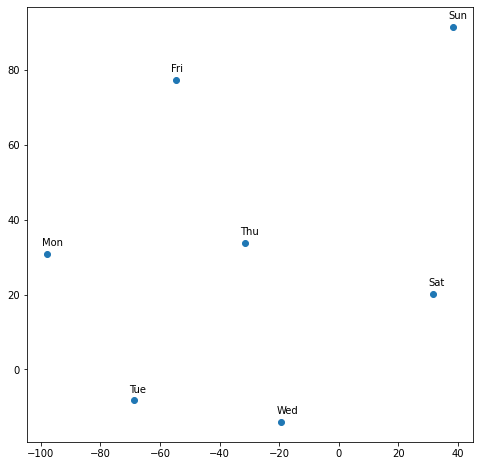

In [45]:
import pickle
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

with open("files/embeddings.pickle", 'rb') as f:
    [store_embedding, dow_embedding, year_embedding, month_embedding, day_embedding, german_states_embedding] = pickle.load(f)

# Load LabelEncoders
with open("files/les.pickle", 'rb') as f:
    les = pickle.load(f)
    le_dow = les[2]


tsne = manifold.TSNE(init='pca', random_state=0, method='exact',perplexity=5, learning_rate=100)
Y = tsne.fit_transform(dow_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')
plt.savefig('dow_embedding.png')

## Table for Q3

In [40]:
rf_mape = 0.026257
xg_boost_mape = 0.042468
nn_mape = 0.012263
rf_emb_mape = 0.0336
xg_boost_emb_mape = 0.0356
nn_emb_mape = ''

mapes = {'MAPE': {'Random Forest': rf_mape, 'XGBoost': xg_boost_mape, 'Neural Network': nn_mape},
         'MAPE (With EE)': {'Random Forest': rf_emb_mape, 'XGBoost': xg_boost_emb_mape, 'Neural Network': nn_emb_mape}}

In [41]:
table = pd.DataFrame(mapes)
table.reset_index(inplace=True)
table.rename(columns={'index': 'method'}, inplace=True)
table

,method,MAPE,MAPE (With EE)
0,Random Forest,0.026257,0.0336
1,XGBoost,0.042468,0.0356
2,Neural Network,0.012263,
